In [1]:
import os
import sys
import zarr
import numpy as np
import xarray as xr
from glob import glob

In [2]:
#import wrf

In [3]:
sys.path.insert(0, os.path.realpath('../libs/'))
import plevel_utils as pu

In [4]:
import cmaps
# graph tools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.colorbar as cbar
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature

%matplotlib inline

In [5]:
# import matplotlib.pyplot as plt
# %matplotlib inline

In [6]:
import time

## Variable info

In [7]:
GRAVITY = pu.GRAVITY

def vertical_integral(var, p, g=GRAVITY):
    """
    Compute pressure-level vertical integral using the trapezoidal rule:
    ∫ var * dp / g
    
    Parameters:
        var (xr.DataArray): Variable to integrate (e.g., q, q*u, q*v)
        p   (xr.DataArray): Pressure with same dimensions as var
        g   (float): Gravitational acceleration (default 9.80665 m/s²)
        
    Returns:
        xr.DataArray: Vertically integrated result with bottom_top removed
    """
    dp = -p.diff(dim='bottom_top')
    var_mid = 0.5 * (var.isel(bottom_top=slice(0, -1)) + var.isel(bottom_top=slice(1, None)))
    return ((var_mid * dp) / g).sum(dim='bottom_top')


def wrf_destag(darray, stagger_dim):
    if stagger_dim not in darray.dims:
        raise ValueError(f"Dimension '{stagger_dim}' not found in input DataArray.")
    
    return 0.5 * (darray.isel({stagger_dim: slice(0, -1)}) +
                  darray.isel({stagger_dim: slice(1, None)}))

var_2d = [
    'ACDEWC', 'ACDRIPR', 'ACDRIPS', 'ACECAN', 'ACEDIR', 'ACETLSM',
    'ACETRAN', 'ACEVAC', 'ACEVB', 'ACEVC', 'ACEVG', 'ACFROC',
    'ACFRZC', 'ACGHB', 'ACGHFLSM', 'ACGHV', 'ACINTR', 'ACINTS',
    'ACIRB', 'ACIRC', 'ACIRG', 'ACLHFLSM', 'ACLWDNB', 'ACLWDNBC',
    'ACLWDNLSM', 'ACLWDNT', 'ACLWDNTC', 'ACLWUPB', 'ACLWUPBC', 'ACLWUPLSM',
    'ACLWUPT', 'ACLWUPTC', 'ACMELTC', 'ACPAHB', 'ACPAHG', 'ACPAHLSM',
    'ACPAHV', 'ACPONDING', 'ACQLAT', 'ACQRF', 'ACRAINLSM', 'ACRAINSNOW',
    'ACRUNSB', 'ACRUNSF', 'ACSAGB', 'ACSAGV', 'ACSAV', 'ACSHB',
    'ACSHC', 'ACSHFLSM', 'ACSHG', 'ACSNBOT', 'ACSNFRO', 'ACSNOM',
    'ACSNOWLSM', 'ACSNSUB', 'ACSUBC', 'ACSWDNB', 'ACSWDNBC', 'ACSWDNLSM',
    'ACSWDNT', 'ACSWDNTC', 'ACSWUPB', 'ACSWUPBC', 'ACSWUPLSM', 'ACSWUPT',
    'ACSWUPTC', 'ACTHROR', 'ACTHROS', 'ACTR', 'ALBEDO', 'CANICE',
    'CANWAT', 'COSZEN', 'EMISS', 'FORCPLSM', 'FORCQLSM', 'FORCTLSM',
    'FORCWLSM', 'FORCZLSM', 'GLW', 'GRAUPEL_ACC_NC', 'HFX', 'I_ACLWDNB',
    'I_ACLWDNBC', 'I_ACLWDNT', 'I_ACLWDNTC', 'I_ACLWUPB', 'I_ACLWUPBC', 'I_ACLWUPT',
    'I_ACLWUPTC', 'I_ACSWDNB', 'I_ACSWDNBC', 'I_ACSWDNT', 'I_ACSWDNTC', 'I_ACSWUPB',
    'I_ACSWUPBC', 'I_ACSWUPT', 'I_ACSWUPTC', 'LAI', 'LH', 'LWDNB',
    'LWDNBC', 'LWDNT', 'LWDNTC', 'LWUPB', 'LWUPBC', 'LWUPT',
    'LWUPTC', 'MLCAPE', 'MLCINH', 'MLLCL', 'MU', 'MUCAPE',
    'MUCINH', 'OLR', 'P', 'PBLH', 'PREC_ACC_NC', 'PSFC',
    'PWAT', 'Q2', 'QFX', 'QRFS', 'QSLAT', 'QSPRINGS',
    'QVAPOR', 'RAINNCV', 'RECH', 'REFL_10CM', 'REFL_1KM_AGL', 'REFL_COM',
    'SBCAPE', 'SBCINH', 'SBLCL', 'SEAICE', 'SH2O', 'SMCWTD',
    'SMOIS', 'SNICE', 'SNLIQ', 'SNOW', 'SNOWC', 'SNOWENERGY',
    'SNOWH', 'SNOW_ACC_NC', 'SOILENERGY', 'SR', 'SRH01', 'SRH03',
    'SST', 'SSTSK', 'SWDNB', 'SWDNBC', 'SWDNT', 'SWDNTC',
    'SWDOWN', 'SWNORM', 'SWUPB', 'SWUPBC', 'SWUPT', 'SWUPTC',
    'T2', 'TD2', 'TG', 'TH2', 'TK', 'TRAD',
    'TSK', 'TSLB', 'TSNO', 'TV', 'Times', 'U',
    'U10', 'USHR1', 'USHR6', 'UST', 'U_BUNK', 'V',
    'V10', 'VSHR1', 'VSHR6', 'V_BUNK', 'W', 'Z',
    'ZSNSO', 'ZWT', 'totalIce', 'totalLiq', 'totalVap',
    'index_snow_layers_stag', 'index_snso_layers_stag', 'index_soil_layers_stag'
]

# QCLOUD, QGRAUP, QICE, QRAIN, QSNOW

var_3d = [
    'CLDFRA', 'O3RAD', 'P', 'P_HYD', 'QCLOUD',
    'QGRAUP', 'QICE', 'QNICE', 'QNRAIN', 'QRAIN',
    'QSNOW', 'QVAPOR', 'REFL_10CM', 'TK', 'Times',
    'U', 'V', 'W', 'Z', 'ilev', 'lev'
]

var_2d_pick = [
    'T2', 'TD2', 'U10', 'V10', 'PSFC', 'ACETLSM', 
    'PREC_ACC_NC', 'PWAT', 'REFL_COM', 'OLR', 'Z', 
    'PSFC', 'SWDOWN', 'GLW', 'SBCAPE', 'SMOIS', 'TSLB'
]

var_3d_pick= ['TK', 'U', 'V', 'P', 'Z', 'W', 'CLDFRA', 'QVAPOR', 
              'QCLOUD', 'QGRAUP', 'QICE', 'QRAIN', 'QSNOW']

var_2d_drop = list(set(var_2d) - set(var_2d_pick))
var_3d_drop = list(set(var_3d) - set(var_3d_pick))

rename_final = {
    'T2': 'WRF_T2',
    'TD2': 'WRF_TD2',
    'U10': 'WRF_U10',
    'V10': 'WRF_V10',
    'ACETLSM': 'WRF_evapor', 
    'PREC_ACC_NC': 'WRF_precip', 
    'PSFC': 'WRF_SP',
    'PWAT': 'WRF_PWAT',
    'TK_3d': 'WRF_T',
    'P_3d': 'WRF_P',
    'Z_3d': 'WRF_Z',
    'W': 'WRF_W',
    'U': 'WRF_U',
    'V': 'WRF_V',
    'QVAPOR': 'WRF_Q',
    'REFL_COM': 'WRF_radar_composite',
    'SBCAPE': 'WRF_SBCAPE', 
    'SMOIS': 'WRF_SMOIS', 
    'TSLB': 'WRF_TSLB',
    'OLR': 'WRF_OLR',
    'GLW': 'WRF_GLW',
    'SWDOWN': 'WRF_SWDOWN'
}

varname_4d = [
    'WRF_T',
    'WRF_P',
    'WRF_U',
    'WRF_V',
    'WRF_Q',
    'WRF_W',
    'WRF_Q_tot'
    'WRF_Q_LC'
]

rename_3d = {'TK': 'TK_3d', 'P': 'P_3d', 'Z': 'Z_3d'}
rename_2d = {'Z': 'Z_2d'}

In [8]:
# level_pick = [0, 6, 9, 12, 15, 18, 21, 24, 30, 36, 42, 48]
# level_pick = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 21, 24, 30, 36, 42, 49]

varname_time = 'Time'
varname_lat = 'south_north'
varname_lon = 'west_east'

dim_3D = (varname_time, varname_lat, varname_lon)

## Native model level main loop

In [9]:
domain_inds = np.arange(336).astype(np.float32)

level_pick = [0, 3, 6, 9, 12, 15, 18, 21, 24, 30, 36, 42]
level_inds = np.arange(len(level_pick)).astype(np.float32)

pressure = np.array(
    [1000, 946, 915, 867, 800, 715, 610, 500, 420, 280, 180, 100]
).astype(np.float32)

In [10]:
fn_2d_full = sorted(glob('/glade/campaign/ncar/USGS_Water/CONUS404_WY2023/WY*/wrf2d*'))

In [11]:
len(fn_2d_full)

17544

## 2023, 2024

In [12]:
ind_start = 16000
ind_end = 16001

fn_2d_full = sorted(glob('/glade/campaign/ncar/USGS_Water/CONUS404_WY2023/WY*/wrf2d*'))

fn_2d_subset = fn_2d_full[ind_start:ind_end]
L = len(fn_2d_subset)

for i in range(L):
    start_time = time.time()    
    fn_2d = fn_2d_subset[i]
    fn_3d = fn_2d[:58] + '3d' + fn_2d[60:] # fn_2d[:62] + '3d' + fn_2d[64:]
    
    ds_2d = xr.open_dataset(fn_2d, drop_variables=var_2d_drop)
    # ds_2d = ds_2d.drop_vars(['XLAT_U', 'XLONG_U', 'XLAT_V', 'XLONG_V'])

    ds_2d['SMOIS'] = ds_2d['SMOIS'].isel(soil_layers_stag=0)
    ds_2d['TSLB'] = ds_2d['TSLB'].isel(soil_layers_stag=0)
    
    # ------------------------------------------------------------ #
    # 3d destag
    ds_3d = xr.open_dataset(fn_3d, drop_variables=var_3d_drop)
    
    # convert to geopotential
    ds_3d['Z'] = ds_3d['Z'] * GRAVITY 
    
    Z_destag_3d = wrf_destag(ds_3d['Z'], 'bottom_top_stag')
    Z_destag_3d = Z_destag_3d.rename({'bottom_top_stag': 'bottom_top'})
    ds_3d = ds_3d.drop_vars(['Z',])
    ds_3d['Z'] = Z_destag_3d
    
    W_destag_3d = wrf_destag(ds_3d['W'], 'bottom_top_stag')
    W_destag_3d = W_destag_3d.rename({'bottom_top_stag': 'bottom_top'})
    ds_3d = ds_3d.drop_vars(['W',])
    ds_3d['W'] = W_destag_3d
    
    U_destag_3d = wrf_destag(ds_3d['U'], 'west_east_stag')
    U_destag_3d = U_destag_3d.rename({'west_east_stag': 'west_east'})
    ds_3d = ds_3d.drop_vars(['U',])
    ds_3d['U'] = U_destag_3d
    
    V_destag_3d = wrf_destag(ds_3d['V'], 'south_north_stag')
    V_destag_3d = V_destag_3d.rename({'south_north_stag': 'south_north'})
    ds_3d = ds_3d.drop_vars(['V',])
    ds_3d['V'] = V_destag_3d
    
    # ds_3d = ds_3d.drop_vars(['XLAT_U', 'XLONG_U', 'XLAT_V', 'XLONG_V'])
    
    # -------------------------------------------------------- #
    # merge together
    ds_2d = ds_2d.rename(rename_2d)
    ds_3d = ds_3d.rename(rename_3d)
    
    ds_mlevel = xr.merge([ds_2d, ds_3d])    
    ds_mlevel = ds_mlevel.isel(west_east=slice(570, 905+1, 1), south_north=slice(200, 535+1, 1))
    ds_mlevel = ds_mlevel.map(lambda x: x.astype(np.float32) if x.dtype == np.float64 else x)

    # -------------------------------------------------------- #
    # Q_tot
    ds_mlevel['WRF_Q_tot'] = ds_mlevel['QVAPOR'] + \
                             ds_mlevel['QCLOUD'] + \
                             ds_mlevel['QGRAUP'] + \
                             ds_mlevel['QICE'] + \
                             ds_mlevel['QRAIN'] + \
                             ds_mlevel['QSNOW']
    
    ds_mlevel['WRF_Q_LC'] = ds_mlevel['QCLOUD'] + \
                            ds_mlevel['QGRAUP'] + \
                            ds_mlevel['QICE'] + \
                            ds_mlevel['QRAIN'] + \
                            ds_mlevel['QSNOW'] 
    
    # integrate_Q_LC
    ds_mlevel['WRF_PWAT_LC'] = vertical_integral(ds_mlevel['WRF_Q_LC'], ds_mlevel['P_3d'])
    
    # # IVT components
    # ds_mlevel['WRF_IVT_U'] = vertical_integral(ds_mlevel['WRF_Q_tot'] * ds_mlevel['U'], ds_mlevel['P_3d'])
    # ds_mlevel['WRF_IVT_V'] = vertical_integral(ds_mlevel['WRF_Q_tot'] * ds_mlevel['V'], ds_mlevel['P_3d'])
    
    # -------------------------------------------------------- #
    # MSLP conversion
    ds_raw = ds_mlevel
    
    coords_surface = {
            varname_time: ds_raw[varname_time],
            varname_lat: ds_raw[varname_lat],
            varname_lon: ds_raw[varname_lon],
    }
    
    pressure_3D = ds_raw['P_3d'].values
    GP_3D = ds_raw['Z_3d'].values
    T_3D = ds_raw['TK_3d'].values
    Z_model_bot = ds_raw['Z_2d'].values
    PSFC = ds_raw['PSFC'].values

    MSLP = xr.Dataset(
        data_vars={
            'WRF_MSLP': xr.DataArray(
                coords=coords_surface,
                dims=dim_3D,
                name='WRF_MSLP',
            )
        },
        coords=coords_surface,
    )

    for t, time_val in enumerate(ds_raw[varname_time]):
        MSLP['WRF_MSLP'][t] = (
            pu.MSLP_convert(
                PSFC[t],
                T_3D[t],
                pressure_3D[t],
                Z_model_bot[t],
                GP_3D[t],
                temp_height=150.0,
            )
        )
        
    # -------------------------------------------------------- #
    # Total Cloud Cover (TCC)
    ds_mlevel['WRF_TCC'] = 1.0 - (1.0 - ds_mlevel['CLDFRA']).prod(dim='bottom_top', skipna=False)
    
    ds_mlevel = xr.merge([ds_mlevel, MSLP])

    ds_mlevel = ds_mlevel.map(lambda x: x.astype(np.float32) if x.dtype == np.float64 else x)
    ds_mlevel = ds_mlevel.drop_vars(['QCLOUD', 'QGRAUP', 'QICE', 'QRAIN', 'QSNOW', 
                                     'Z_2d', 'CLDFRA'])
    
    ds_mlevel = ds_mlevel.isel(bottom_top=level_pick)
    ds_mlevel = ds_mlevel.rename(rename_final)
    
    ds_mlevel = ds_mlevel.rename({'Time': 'time'})    
    ds_mlevel = ds_mlevel.reset_coords(drop=True)
    ds_mlevel = ds_mlevel.assign_coords(
        south_north=domain_inds, 
        west_east=domain_inds, 
        bottom_top=level_inds,
        pressure_approx=pressure
    )
    
    if i == 0:
        varnames = list(ds_mlevel.keys())
        # zarr encodings
        dict_encoding = {}
        
        chunk_size_3d = dict(chunks=(12, 336, 336))
        chunk_size_4d = dict(chunks=(12, 12, 336, 336))
        
        compress = zarr.Blosc(cname='zstd', clevel=1, shuffle=zarr.Blosc.SHUFFLE, blocksize=0)
        
        for i_var, var in enumerate(varnames):
            if var in varname_4d:
                dict_encoding[var] = {'compressor': compress, **chunk_size_4d}
            else:
                dict_encoding[var] = {'compressor': compress, **chunk_size_3d}
    
    save_name = '/glade/campaign/ral/hap/ksha/DWC_data/CONUS_domain_GP/raw_404_new/' + 'C404_PG_' + fn_2d[-19:-6] + 'H.zarr'
    print(save_name)
    # ds_mlevel.to_zarr(save_name, mode='w', consolidated=True, compute=True, encoding=dict_encoding)
    print("--- %s seconds ---" % (time.time() - start_time))

/glade/campaign/ral/hap/ksha/DWC_data/CONUS_domain_GP/raw_404_new/C404_PG_2024-07-28_16H.zarr
--- 24.687615156173706 seconds ---


In [14]:
ds_mlevel['WRF_T2'].values

array([[[298.48685, 298.19943, 296.91727, ..., 302.6095 , 302.61716,
         302.61633],
        [298.3567 , 297.88556, 295.6169 , ..., 302.6119 , 302.6144 ,
         302.61346],
        [298.2676 , 297.2873 , 294.56485, ..., 302.61896, 302.61734,
         302.6195 ],
        ...,
        [301.94458, 302.19672, 302.4579 , ..., 300.74585, 299.96292,
         300.44754],
        [301.88864, 302.12796, 302.4615 , ..., 300.5517 , 299.806  ,
         300.63287],
        [301.91797, 302.10992, 302.38516, ..., 300.48236, 299.90024,
         300.67273]]], dtype=float32)

In [16]:
ds = xr.open_zarr('/glade/campaign/ral/hap/ksha/DWC_data/CONUS_domain_GP/raw_404_new/C404_PG_2024-07-28_16H.zarr')

In [17]:
ds['WRF_T2'].values

array([[[298.48685, 298.19943, 296.91727, ..., 302.6095 , 302.61716,
         302.61633],
        [298.3567 , 297.88556, 295.6169 , ..., 302.6119 , 302.6144 ,
         302.61346],
        [298.2676 , 297.2873 , 294.56485, ..., 302.61896, 302.61734,
         302.6195 ],
        ...,
        [301.94458, 302.19672, 302.4579 , ..., 300.74585, 299.96292,
         300.44754],
        [301.88864, 302.12796, 302.4615 , ..., 300.5517 , 299.806  ,
         300.63287],
        [301.91797, 302.10992, 302.38516, ..., 300.48236, 299.90024,
         300.67273]]], dtype=float32)

In [18]:
ds

<xarray.Dataset>
Dimensions:              (time: 1, south_north: 336, west_east: 336,
                          bottom_top: 12, pressure_approx: 12)
Coordinates:
  * bottom_top           (bottom_top) float32 0.0 1.0 2.0 3.0 ... 9.0 10.0 11.0
  * pressure_approx      (pressure_approx) float32 1e+03 946.0 ... 180.0 100.0
  * south_north          (south_north) float32 0.0 1.0 2.0 ... 333.0 334.0 335.0
  * time                 (time) int64 0
  * west_east            (west_east) float32 0.0 1.0 2.0 ... 333.0 334.0 335.0
Data variables: (12/28)
    WRF_GLW              (time, south_north, west_east) float32 dask.array<chunksize=(1, 336, 336), meta=np.ndarray>
    WRF_MSLP             (time, south_north, west_east) float32 dask.array<chunksize=(1, 336, 336), meta=np.ndarray>
    WRF_OLR              (time, south_north, west_east) float32 dask.array<chunksize=(1, 336, 336), meta=np.ndarray>
    WRF_P                (time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(1, 12, 336, 336), meta=np.ndarray>
    WRF_PWAT             (time, south_north, west_east) float32 dask.array<chunksize=(1, 336, 336), meta=np.ndarray>
    WRF_PWAT_LC          (time, south_north, west_east) float32 dask.array<chunksize=(1, 336, 336), meta=np.ndarray>
    ...                   ...
    WRF_W                (time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(1, 12, 336, 336), meta=np.ndarray>
    WRF_Z                (time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(1, 3, 168, 168), meta=np.ndarray>
    WRF_evapor           (time, south_north, west_east) float32 dask.array<chunksize=(1, 336, 336), meta=np.ndarray>
    WRF_precip           (time, south_north, west_east) float32 dask.array<chunksize=(1, 336, 336), meta=np.ndarray>
    WRF_radar_composite  (time, south_north, west_east) float32 dask.array<chunksize=(1, 336, 336), meta=np.ndarray>
    XTIME                (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>

In [20]:
save_name

'/glade/campaign/ral/hap/ksha/DWC_data/CONUS_domain_GP/raw_404_new/C404_PG_2022-10-05_04H.zarr'

In [26]:
fn_2d[:58] + '3d' + fn_2d[60:]

'/glade/campaign/ncar/USGS_Water/CONUS404_WY2023/WY2023/wrf3d_d01_2022-10-05_04:00:00'

In [20]:
fn_3d

'/glade/campaign/ncar/USGS_Water/CONUS404_WY2023/WY2023/wrf2d_d3d_2022-10-05_04:00:00'

In [21]:
fn_2d

'/glade/campaign/ncar/USGS_Water/CONUS404_WY2023/WY2023/wrf2d_d01_2022-10-05_04:00:00'

In [18]:
ds_2d

<xarray.Dataset>
Dimensions:      (Time: 1, south_north: 1015, west_east: 1367,
                  soil_layers_stag: 4)
Dimensions without coordinates: Time, south_north, west_east, soil_layers_stag
Data variables: (12/17)
    T2           (Time, south_north, west_east) float32 ...
    PSFC         (Time, south_north, west_east) float32 ...
    U10          (Time, south_north, west_east) float32 ...
    V10          (Time, south_north, west_east) float32 ...
    XTIME        (Time) datetime64[ns] ...
    TSLB         (Time, soil_layers_stag, south_north, west_east) float32 ...
    ...           ...
    REFL_COM     (Time, south_north, west_east) float32 ...
    SBCAPE       (Time, south_north, west_east) float32 ...
    TD2          (Time, south_north, west_east) float32 ...
    PREC_ACC_NC  (Time, south_north, west_east) float32 ...
    Z            (Time, south_north, west_east) float32 ...
    PWAT         (Time, south_north, west_east) float32 ...
Attributes: (12/145)
    TITLE:                            OUTPUT FROM WRF V3.9.1.1 MODEL
    START_DATE:                      2022-10-01_00:00:00
    SIMULATION_START_DATE:           1979-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1368
    SOUTH-NORTH_GRID_DIMENSION:      1016
    BOTTOM-TOP_GRID_DIMENSION:       51
    ...                              ...
    ETAC:                            0.0
    Source_Code:                     make_conusii_2d.csh
    FileGenerated:                   20240921
    Project:                         USGS CONUS404
    Division:                        NCAR/RAL/HAP
    Contacts:                        CHANGHAI LIU (chliu@ucar.edu), KYOKO IKE...

## 1980-2022

In [16]:
# ind_start = 100
# ind_end = 101

# fn_2d_full = sorted(glob('/glade/campaign/collections/rda/data/d559000/wy*/*/wrf2d*'))
# # fn_2d_full = sorted(glob('/glade/campaign/ncar/USGS_Water/CONUS404_WY2023/WY*/wrf2d*'))

# fn_2d_subset = fn_2d_full[ind_start:ind_end]
# L = len(fn_2d_subset)

# for i in range(L):
#     start_time = time.time()    
#     fn_2d = fn_2d_subset[i]
#     fn_3d = fn_2d[:62] + '3d' + fn_2d[64:]
    
#     ds_2d = xr.open_dataset(fn_2d, drop_variables=var_2d_drop)
#     ds_2d = ds_2d.drop_vars(['XLAT_U', 'XLONG_U', 'XLAT_V', 'XLONG_V'])

#     ds_2d['SMOIS'] = ds_2d['SMOIS'].isel(soil_layers_stag=0)
#     ds_2d['TSLB'] = ds_2d['TSLB'].isel(soil_layers_stag=0)
    
#     # ------------------------------------------------------------ #
#     # 3d destag
#     ds_3d = xr.open_dataset(fn_3d, drop_variables=var_3d_drop)
    
#     # convert to geopotential
#     ds_3d['Z'] = ds_3d['Z'] * GRAVITY 
    
#     Z_destag_3d = wrf_destag(ds_3d['Z'], 'bottom_top_stag')
#     Z_destag_3d = Z_destag_3d.rename({'bottom_top_stag': 'bottom_top'})
#     ds_3d = ds_3d.drop_vars(['Z',])
#     ds_3d['Z'] = Z_destag_3d
    
#     W_destag_3d = wrf_destag(ds_3d['W'], 'bottom_top_stag')
#     W_destag_3d = W_destag_3d.rename({'bottom_top_stag': 'bottom_top'})
#     ds_3d = ds_3d.drop_vars(['W',])
#     ds_3d['W'] = W_destag_3d
    
#     U_destag_3d = wrf_destag(ds_3d['U'], 'west_east_stag')
#     U_destag_3d = U_destag_3d.rename({'west_east_stag': 'west_east'})
#     ds_3d = ds_3d.drop_vars(['U',])
#     ds_3d['U'] = U_destag_3d
    
#     V_destag_3d = wrf_destag(ds_3d['V'], 'south_north_stag')
#     V_destag_3d = V_destag_3d.rename({'south_north_stag': 'south_north'})
#     ds_3d = ds_3d.drop_vars(['V',])
#     ds_3d['V'] = V_destag_3d
    
#     ds_3d = ds_3d.drop_vars(['XLAT_U', 'XLONG_U', 'XLAT_V', 'XLONG_V'])
    
#     # -------------------------------------------------------- #
#     # merge together
#     ds_2d = ds_2d.rename(rename_2d)
#     ds_3d = ds_3d.rename(rename_3d)
    
#     ds_mlevel = xr.merge([ds_2d, ds_3d])    
#     ds_mlevel = ds_mlevel.isel(west_east=slice(570, 905+1, 1), south_north=slice(200, 535+1, 1))
#     ds_mlevel = ds_mlevel.map(lambda x: x.astype(np.float32) if x.dtype == np.float64 else x)

#     # -------------------------------------------------------- #
#     # Q_tot
#     ds_mlevel['WRF_Q_tot'] = ds_mlevel['QVAPOR'] + \
#                              ds_mlevel['QCLOUD'] + \
#                              ds_mlevel['QGRAUP'] + \
#                              ds_mlevel['QICE'] + \
#                              ds_mlevel['QRAIN'] + \
#                              ds_mlevel['QSNOW']
    
#     ds_mlevel['WRF_Q_LC'] = ds_mlevel['QCLOUD'] + \
#                             ds_mlevel['QGRAUP'] + \
#                             ds_mlevel['QICE'] + \
#                             ds_mlevel['QRAIN'] + \
#                             ds_mlevel['QSNOW'] 
    
#     # integrate_Q_LC
#     ds_mlevel['WRF_PWAT_LC'] = vertical_integral(ds_mlevel['WRF_Q_LC'], ds_mlevel['P_3d'])
    
#     # # IVT components
#     # ds_mlevel['WRF_IVT_U'] = vertical_integral(ds_mlevel['WRF_Q_tot'] * ds_mlevel['U'], ds_mlevel['P_3d'])
#     # ds_mlevel['WRF_IVT_V'] = vertical_integral(ds_mlevel['WRF_Q_tot'] * ds_mlevel['V'], ds_mlevel['P_3d'])
    
#     # -------------------------------------------------------- #
#     # MSLP conversion
#     ds_raw = ds_mlevel
    
#     coords_surface = {
#             varname_time: ds_raw[varname_time],
#             varname_lat: ds_raw[varname_lat],
#             varname_lon: ds_raw[varname_lon],
#     }
    
#     pressure_3D = ds_raw['P_3d'].values
#     GP_3D = ds_raw['Z_3d'].values
#     T_3D = ds_raw['TK_3d'].values
#     Z_model_bot = ds_raw['Z_2d'].values
#     PSFC = ds_raw['PSFC'].values

#     MSLP = xr.Dataset(
#         data_vars={
#             'WRF_MSLP': xr.DataArray(
#                 coords=coords_surface,
#                 dims=dim_3D,
#                 name='WRF_MSLP',
#             )
#         },
#         coords=coords_surface,
#     )

#     for t, time_val in enumerate(ds_raw[varname_time]):
#         MSLP['WRF_MSLP'][t] = (
#             pu.MSLP_convert(
#                 PSFC[t],
#                 T_3D[t],
#                 pressure_3D[t],
#                 Z_model_bot[t],
#                 GP_3D[t],
#                 temp_height=150.0,
#             )
#         )
        
#     # -------------------------------------------------------- #
#     # Total Cloud Cover (TCC)
#     ds_mlevel['WRF_TCC'] = 1.0 - (1.0 - ds_mlevel['CLDFRA']).prod(dim='bottom_top', skipna=False)
    
#     ds_mlevel = xr.merge([ds_mlevel, MSLP])

#     ds_mlevel = ds_mlevel.map(lambda x: x.astype(np.float32) if x.dtype == np.float64 else x)
#     ds_mlevel = ds_mlevel.drop_vars(['QCLOUD', 'QGRAUP', 'QICE', 'QRAIN', 'QSNOW', 
#                                      'Z_2d', 'CLDFRA'])
    
#     ds_mlevel = ds_mlevel.isel(bottom_top=level_pick)
#     ds_mlevel = ds_mlevel.rename(rename_final)
    
#     ds_mlevel = ds_mlevel.rename({'Time': 'time'})    
#     ds_mlevel = ds_mlevel.reset_coords(drop=True)
#     ds_mlevel = ds_mlevel.assign_coords(
#         south_north=domain_inds, 
#         west_east=domain_inds, 
#         bottom_top=level_inds,
#         pressure_approx=pressure
#     )
    
#     if i == 0:
#         varnames = list(ds_mlevel.keys())
#         # zarr encodings
#         dict_encoding = {}
        
#         chunk_size_3d = dict(chunks=(12, 336, 336))
#         chunk_size_4d = dict(chunks=(12, 12, 336, 336))
        
#         compress = zarr.Blosc(cname='zstd', clevel=1, shuffle=zarr.Blosc.SHUFFLE, blocksize=0)
        
#         for i_var, var in enumerate(varnames):
#             if var in varname_4d:
#                 dict_encoding[var] = {'compressor': compress, **chunk_size_4d}
#             else:
#                 dict_encoding[var] = {'compressor': compress, **chunk_size_3d}
    
#     save_name = '/glade/campaign/ral/hap/ksha/DWC_data/CONUS_domain_GP/raw_404/' + 'C404_PG_' + fn_2d[-22:-9] + 'H.zarr'
#     print(save_name)
#     # ds_mlevel.to_zarr(save_name, mode='w', consolidated=True, compute=True, encoding=dict_encoding)
#     print("--- %s seconds ---" % (time.time() - start_time))

In [15]:
ds_2d

<xarray.Dataset>
Dimensions:      (Time: 1, south_north: 1015, west_east: 1367,
                  soil_layers_stag: 4)
Dimensions without coordinates: Time, south_north, west_east, soil_layers_stag
Data variables: (12/17)
    T2           (Time, south_north, west_east) float32 ...
    PSFC         (Time, south_north, west_east) float32 ...
    U10          (Time, south_north, west_east) float32 ...
    V10          (Time, south_north, west_east) float32 ...
    XTIME        (Time) datetime64[ns] ...
    TSLB         (Time, soil_layers_stag, south_north, west_east) float32 ...
    ...           ...
    REFL_COM     (Time, south_north, west_east) float32 ...
    SBCAPE       (Time, south_north, west_east) float32 ...
    TD2          (Time, south_north, west_east) float32 ...
    PREC_ACC_NC  (Time, south_north, west_east) float32 ...
    Z            (Time, south_north, west_east) float32 ...
    PWAT         (Time, south_north, west_east) float32 ...
Attributes: (12/145)
    TITLE:                            OUTPUT FROM WRF V3.9.1.1 MODEL
    START_DATE:                      2022-10-01_00:00:00
    SIMULATION_START_DATE:           1979-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1368
    SOUTH-NORTH_GRID_DIMENSION:      1016
    BOTTOM-TOP_GRID_DIMENSION:       51
    ...                              ...
    ETAC:                            0.0
    Source_Code:                     make_conusii_2d.csh
    FileGenerated:                   20240921
    Project:                         USGS CONUS404
    Division:                        NCAR/RAL/HAP
    Contacts:                        CHANGHAI LIU (chliu@ucar.edu), KYOKO IKE...

In [13]:
20*60*60 / 30

2400.0

In [12]:
ds_mlevel

<xarray.Dataset>
Dimensions:              (time: 1, south_north: 336, west_east: 336,
                          bottom_top: 12, pressure_approx: 12)
Coordinates:
  * time                 (time) datetime64[ns] 1979-10-05T04:00:00
  * south_north          (south_north) float32 0.0 1.0 2.0 ... 333.0 334.0 335.0
  * west_east            (west_east) float32 0.0 1.0 2.0 ... 333.0 334.0 335.0
  * bottom_top           (bottom_top) float32 0.0 1.0 2.0 3.0 ... 9.0 10.0 11.0
  * pressure_approx      (pressure_approx) float32 1e+03 946.0 ... 180.0 100.0
Data variables: (12/27)
    WRF_evapor           (time, south_north, west_east) float32 ...
    WRF_GLW              (time, south_north, west_east) float32 ...
    WRF_OLR              (time, south_north, west_east) float32 ...
    WRF_precip           (time, south_north, west_east) float32 ...
    WRF_SP               (time, south_north, west_east) float32 8.86e+04 ... ...
    WRF_PWAT             (time, south_north, west_east) float32 ...
    ...                   ...
    WRF_V                (time, bottom_top, south_north, west_east) float32 4...
    WRF_Q_tot            (time, bottom_top, south_north, west_east) float32 0...
    WRF_Q_LC             (time, bottom_top, south_north, west_east) float32 0...
    WRF_PWAT_LC          (time, south_north, west_east) float32 1.812e-05 ......
    WRF_TCC              (time, south_north, west_east) float32 0.0 0.0 ... 0.0
    WRF_MSLP             (time, south_north, west_east) float32 8.989e+04 ......

## Output QC

In [32]:
# ds = xr.open_zarr(
#     '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/raw_404/C404_GP_1979-10-01_00H.zarr'
# )
ds = ds_mlevel

In [33]:
lon_grids = ds['XLONG'].values
lat_grids = ds['XLAT'].values

In [34]:
scale_param = '50m'

PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

def map_gridline_opt(ax):
    '''
    Customize cartopy map gridlines
    '''
    # lat/lon gridlines and labeling

    GL = ax.gridlines(crs=ccrs.PlateCarree(), 
                      draw_labels=False, x_inline=False, y_inline=False, 
                      color='k', linewidth=0.1, linestyle=':', zorder=5)
    GL.top_labels = None; GL.bottom_labels = None
    GL.right_labels = None; GL.left_labels = None
    GL.xlabel_style = {'size': 14}; GL.ylabel_style = {'size': 14}
    GL.rotate_labels = False
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='-', linewidth=2.5, zorder=7)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=2.5, zorder=7)
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param ), edgecolor='k', linewidth=2.5, zorder=5)
    ax.spines['geo'].set_linewidth(2.5)
    return ax

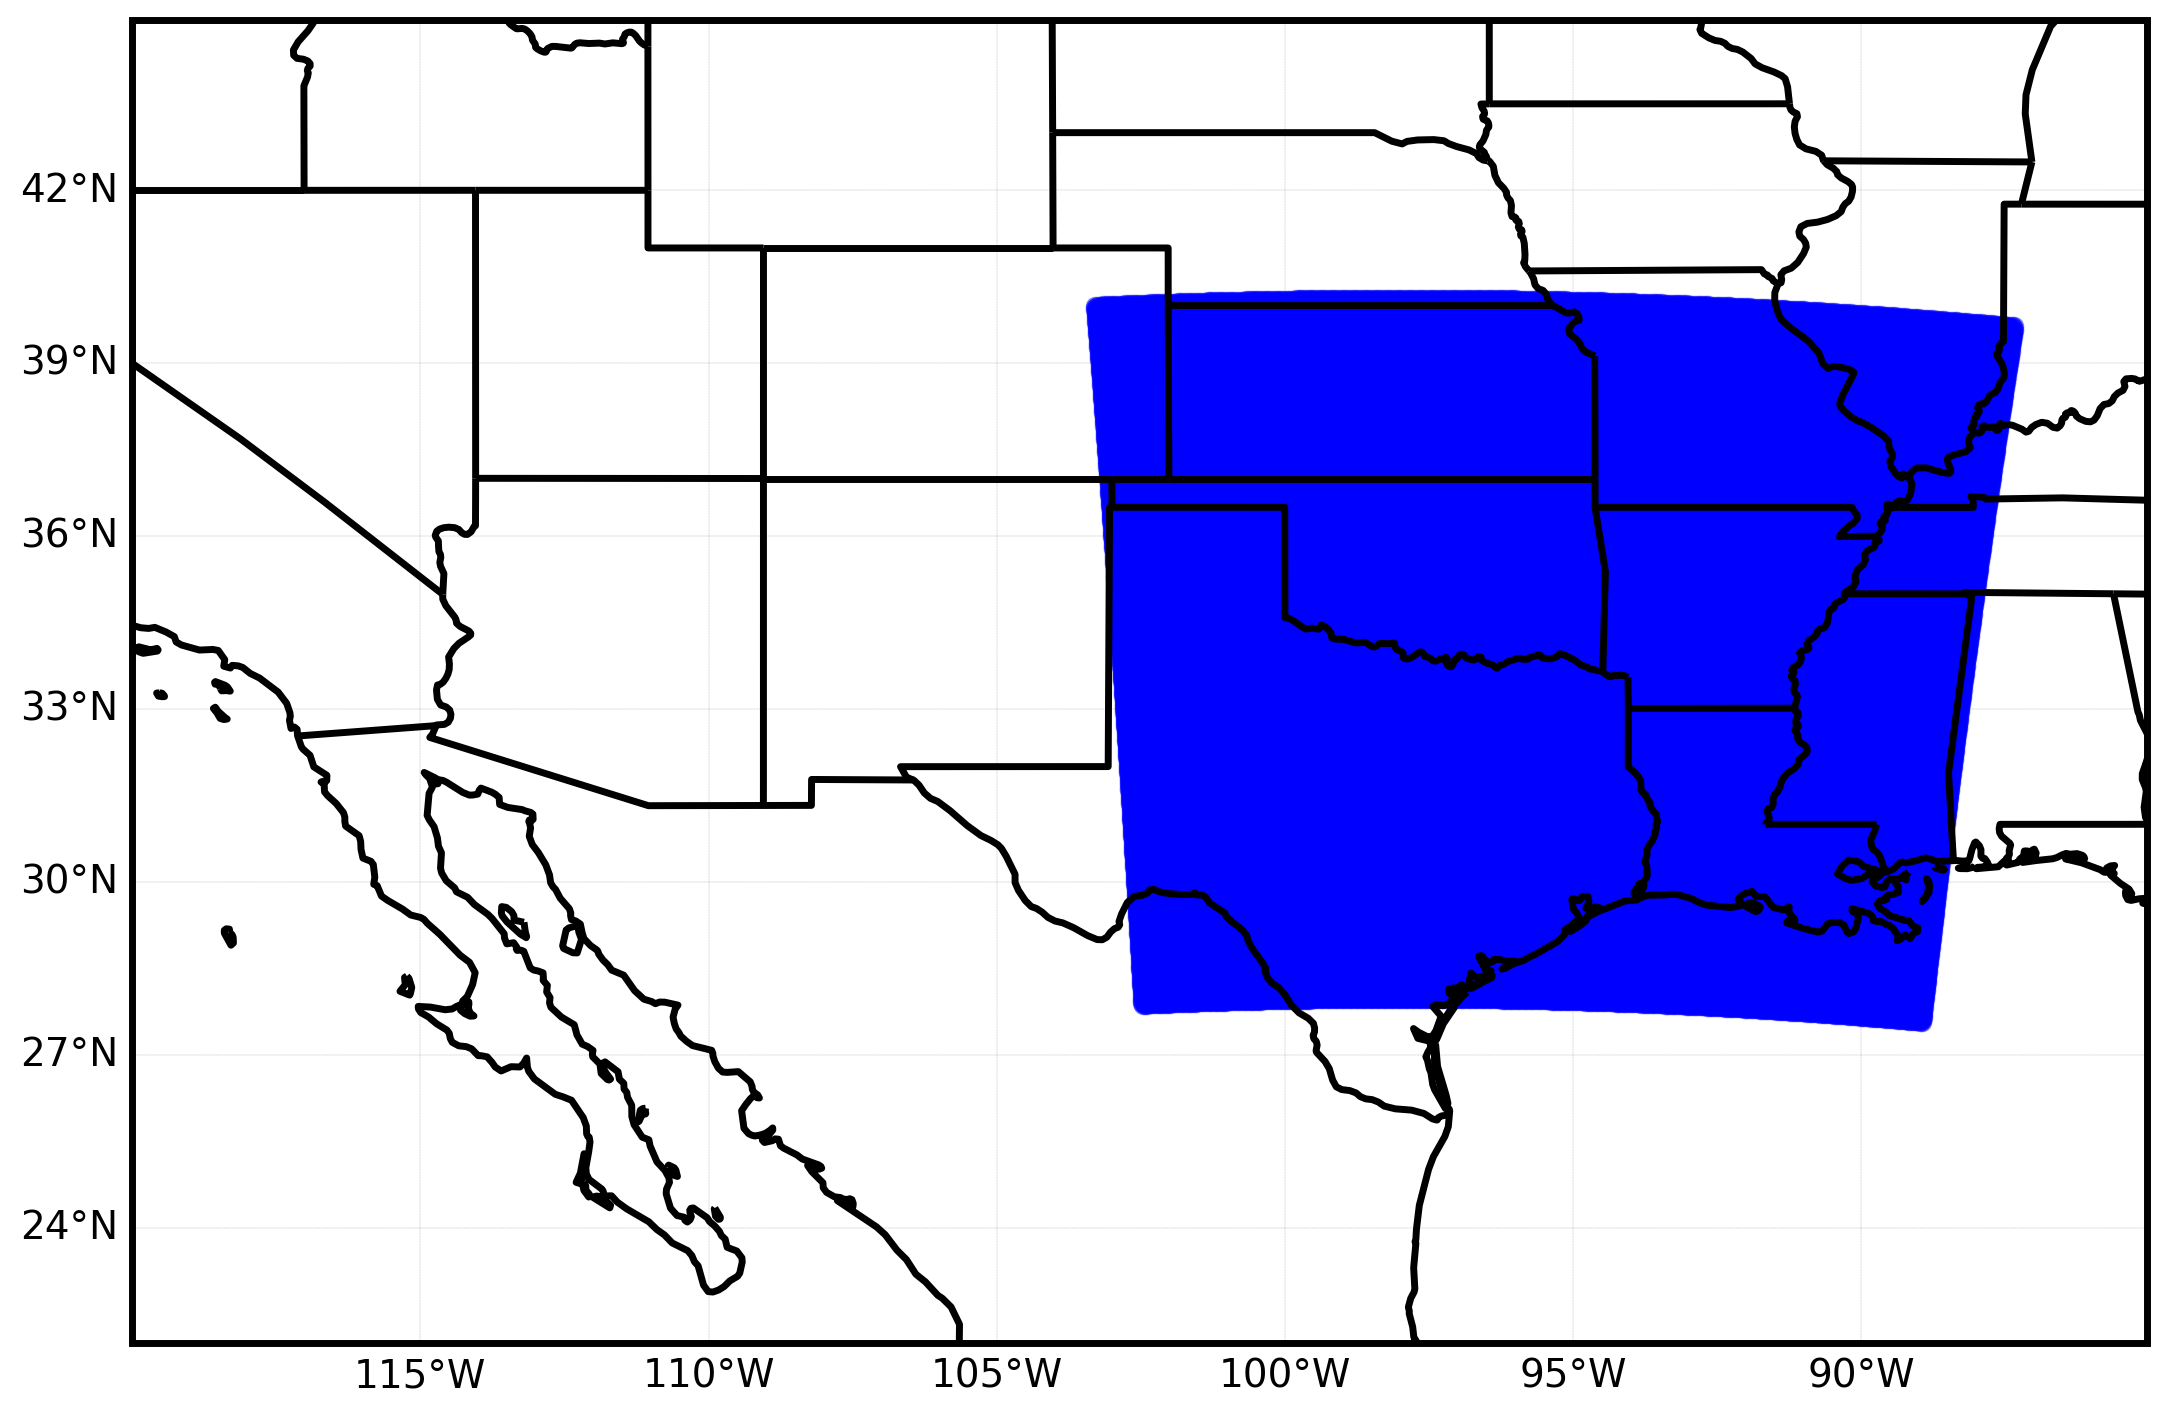

In [35]:
grid = {
    'lon': np.arange(-120, -85, 0.04).astype(np.float32),
    'lat': np.arange(22, 45, 0.04).astype(np.float32)
}

proj_ = ccrs.PlateCarree()
map_extent = [grid['lon'].min(), grid['lon'].max(), grid['lat'].min(), grid['lat'].max()]

fig = plt.figure(figsize=(13, 10), dpi=200)
ax = plt.axes(projection=proj_)
ax.set_extent(map_extent, crs=proj_)
ax = map_gridline_opt(ax)

GL = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True, x_inline=False, y_inline=False, 
    color='k', linewidth=0, linestyle=':', zorder=5
)

GL.top_labels = None
GL.right_labels = None
GL.xlabel_style = {'size': 14}; GL.ylabel_style = {'size': 14}
#GL.xlocator = ticker.FixedLocator([-125, -120, -115, -110])
#GL.ylocator = ticker.FixedLocator([30, 34, 38, 42])


ax.plot(lon_grids.ravel(), lat_grids.ravel(), 'bo', alpha=0.5, transform=ccrs.PlateCarree())

### Notes
* PWAT = totalIce + totalLiq + totalVap
* QCLOUD + QGRAUP + QICE + QRAIN + QSNOW = 1E-2 ~ 1E-4 QVAPOR

In [23]:
QCLOUD = ds_mlevel['QCLOUD'].values[0, ...]
QGRAUP = ds_mlevel['QGRAUP'].values[0, ...]
QICE = ds_mlevel['QICE'].values[0, ...]
QRAIN = ds_mlevel['QRAIN'].values[0, ...]
QSNOW = ds_mlevel['QSNOW'].values[0, ...]
QVAPOR = ds_mlevel['QVAPOR'].values[0, ...]

In [42]:
QCLOUD_prof = QCLOUD.max(axis=(1, 2))
QGRAUP_prof = QGRAUP.max(axis=(1, 2))
QICE_prof = QICE.max(axis=(1, 2))
QRAIN_prof = QRAIN.max(axis=(1, 2))
QSNOW_prof = QSNOW.max(axis=(1, 2))
QVAPOR_prof = QVAPOR.max(axis=(1, 2))

In [43]:
h = np.arange(16)

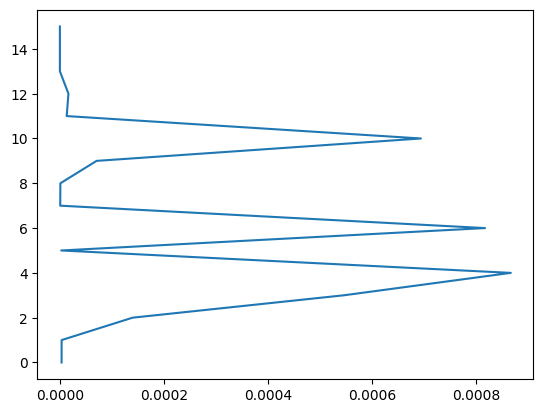

In [44]:
plt.plot(QCLOUD_prof+QGRAUP_prof+QICE_prof+QRAIN_prof+QSNOW_prof, h)

In [45]:
(QCLOUD_prof+QGRAUP_prof+QICE_prof+QRAIN_prof+QSNOW_prof)

array([3.2625317e-06, 3.3162328e-06, 1.3977366e-04, 5.4623006e-04,
       8.6702144e-04, 2.5120175e-06, 8.1749319e-04, 6.4055035e-07,
       9.2632774e-07, 7.0535963e-05, 6.9414312e-04, 1.3072969e-05,
       1.6435946e-05, 2.4816829e-10, 0.0000000e+00, 0.0000000e+00],
      dtype=float32)

In [46]:
QVAPOR_prof

array([1.9525122e-02, 1.8241644e-02, 1.7532507e-02, 1.7015850e-02,
       1.6585203e-02, 1.3405121e-02, 1.1947360e-02, 6.8706051e-03,
       6.0799755e-03, 3.8544864e-03, 2.9353283e-03, 1.3328969e-03,
       2.0079612e-04, 2.3815697e-05, 4.1704138e-06, 2.8918082e-06],
      dtype=float32)

## Domain size

In [12]:
lon_grids = ds['XLONG'].values
lat_grids = ds['XLAT'].values

In [13]:
lon_grids

array([[-102.46948 , -102.42911 , -102.38873 , ...,  -89.02554 ,
         -88.98547 ,  -88.945404],
       [-102.47156 , -102.43118 , -102.39078 , ...,  -89.021515,
         -88.981445,  -88.941345],
       [-102.47363 , -102.43323 , -102.39282 , ...,  -89.01749 ,
         -88.97739 ,  -88.93729 ],
       ...,
       [-103.28656 , -103.23901 , -103.19147 , ...,  -87.44861 ,
         -87.40155 ,  -87.35449 ],
       [-103.28946 , -103.24188 , -103.194305, ...,  -87.443054,
         -87.395935,  -87.34888 ],
       [-103.29236 , -103.24475 , -103.19714 , ...,  -87.43744 ,
         -87.39035 ,  -87.34323 ]], dtype=float32)

In [14]:
lat_grids

array([[27.870647, 27.872475, 27.874302, ..., 27.58118 , 27.577621,
        27.574013],
       [27.90633 , 27.908161, 27.909992, ..., 27.616703, 27.613125,
        27.609547],
       [27.942032, 27.94387 , 27.945671, ..., 27.652233, 27.648647,
        27.645054],
       ...,
       [39.924408, 39.926624, 39.928806, ..., 39.575645, 39.57135 ,
        39.567024],
       [39.96088 , 39.96309 , 39.965282, ..., 39.611923, 39.60762 ,
        39.60329 ],
       [39.99735 , 39.999557, 40.001743, ..., 39.648205, 39.6439  ,
        39.639576]], dtype=float32)

In [15]:
scale_param = '50m'

PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

def map_gridline_opt(ax):
    '''
    Customize cartopy map gridlines
    '''
    # lat/lon gridlines and labeling

    GL = ax.gridlines(crs=ccrs.PlateCarree(), 
                      draw_labels=False, x_inline=False, y_inline=False, 
                      color='k', linewidth=0.1, linestyle=':', zorder=5)
    GL.top_labels = None; GL.bottom_labels = None
    GL.right_labels = None; GL.left_labels = None
    GL.xlabel_style = {'size': 14}; GL.ylabel_style = {'size': 14}
    GL.rotate_labels = False
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='-', linewidth=2.5, zorder=7)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=2.5, zorder=7)
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param ), edgecolor='k', linewidth=2.5, zorder=5)
    ax.spines['geo'].set_linewidth(2.5)
    return ax

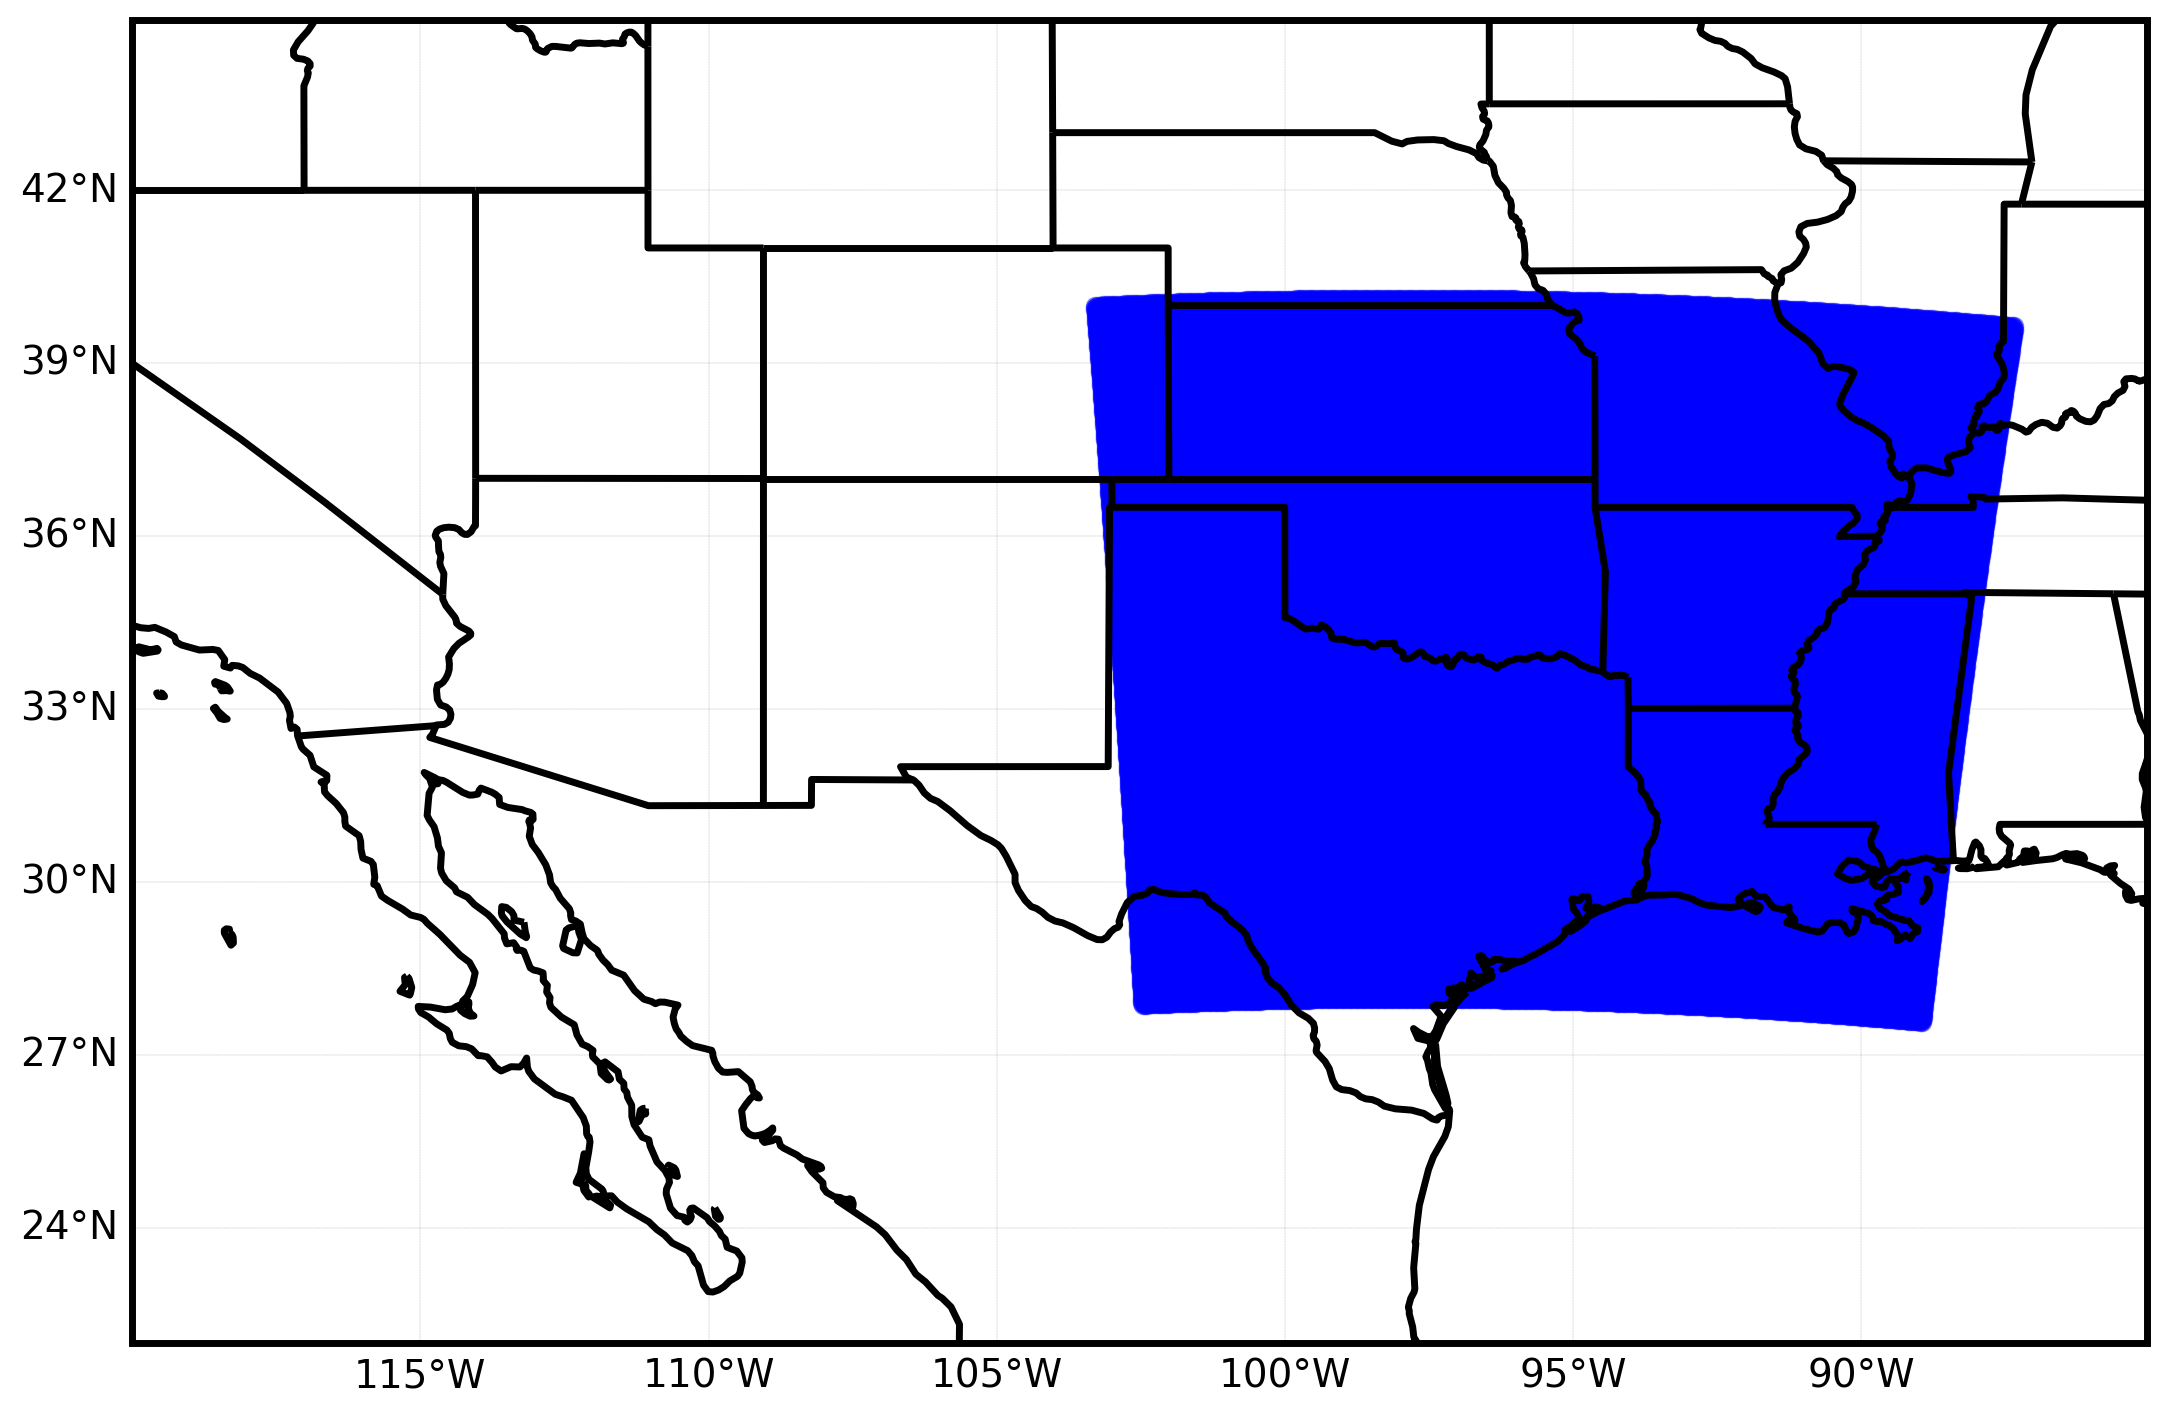

In [16]:
grid = {
    'lon': np.arange(-120, -85, 0.04).astype(np.float32),
    'lat': np.arange(22, 45, 0.04).astype(np.float32)
}

proj_ = ccrs.PlateCarree()
map_extent = [grid['lon'].min(), grid['lon'].max(), grid['lat'].min(), grid['lat'].max()]

fig = plt.figure(figsize=(13, 10), dpi=200)
ax = plt.axes(projection=proj_)
ax.set_extent(map_extent, crs=proj_)
ax = map_gridline_opt(ax)

GL = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True, x_inline=False, y_inline=False, 
    color='k', linewidth=0, linestyle=':', zorder=5
)

GL.top_labels = None
GL.right_labels = None
GL.xlabel_style = {'size': 14}; GL.ylabel_style = {'size': 14}
#GL.xlocator = ticker.FixedLocator([-125, -120, -115, -110])
#GL.ylocator = ticker.FixedLocator([30, 34, 38, 42])


ax.plot(lon_grids.ravel(), lat_grids.ravel(), 'bo', alpha=0.5, transform=ccrs.PlateCarree())